In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
    
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
import sys
import numpy as np
import pandas as pd
import sdata
import uuid
import time
import copy

#lets find databe.py
modulepath = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(modulepath)))

from simple_graph_db import Database

Autosave disabled


05:13:44 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
class Node():
    def __init__(self, name="N.N."):
        self.name = name
        self.uuid = uuid.uuid4().hex
        self.parent = None

    def copy(self, name=None):
        new_node = copy.deepcopy(self)
        new_node.uuid = uuid.uuid4().hex
        new_node.parent = self.uuid
        if name is not None:
            new_node.name = name
        return new_node

    @property
    def data(self):
        return {"name":self.name,
                "uuid":self.uuid,
                "!parent":self.parent}

    def __str__(self):
        return "{0.name}:{0.uuid}".format(self)

    __repr__ = __str__

In [3]:
nodes = []

n0 = Node("n0")
n01 = n0.copy("n01")
n02 = n0.copy("n02")
n011 = n01.copy("n011")
n012 = n01.copy("n012")
print(n0)
print(n01)
nodes.extend([n0, n01, n02, n011, n012])
print(nodes)

n0:4480c7fcbffe4f6aa8db0b8e68d1f36f
n01:7ba78ba1fcd149a1a910b31dc1fd27e3
[n0:4480c7fcbffe4f6aa8db0b8e68d1f36f, n01:7ba78ba1fcd149a1a910b31dc1fd27e3, n02:508d4772e47f4d9ab984ec4782b0c0ae, n011:506eed55ffb04eab879c5df3b1bd130a, n012:a18d770b896947eeb5be44e50f46e54a]


## initialize db

In [4]:

db_file = "/tmp/simple_graph_database.sqlite"
if os.path.exists(db_file):
    os.remove(db_file)

db = Database(db_file=db_file)
print(db)

db.add_node(data={"a":1}, identifier=None)

(DB:'/tmp/simple_graph_database.sqlite')


## add nodes

In [5]:
for node in nodes:
    db.add_node(identifier=node.uuid, data=node.data)

In [6]:
db.find_node(node.uuid)

{'name': 'n012',
 'uuid': 'a18d770b896947eeb5be44e50f46e54a',
 '!parent': '7ba78ba1fcd149a1a910b31dc1fd27e3',
 'id': 'a18d770b896947eeb5be44e50f46e54a'}

## add edges

In [7]:
for node in nodes:
    if node.parent is not None and node.uuid is not None:
        print("{} -> {}".format(node.parent, node.uuid))
        db.connect_nodes(node.parent, node.uuid, {'parent': node.parent})


4480c7fcbffe4f6aa8db0b8e68d1f36f -> 7ba78ba1fcd149a1a910b31dc1fd27e3
4480c7fcbffe4f6aa8db0b8e68d1f36f -> 508d4772e47f4d9ab984ec4782b0c0ae
7ba78ba1fcd149a1a910b31dc1fd27e3 -> 506eed55ffb04eab879c5df3b1bd130a
7ba78ba1fcd149a1a910b31dc1fd27e3 -> a18d770b896947eeb5be44e50f46e54a


## get node by uuid

In [8]:
rn0 = db.find_node(n0.uuid)
print(rn0)
assert n0.uuid == rn0.get("uuid")

{'name': 'n0', 'uuid': '4480c7fcbffe4f6aa8db0b8e68d1f36f', '!parent': None, 'id': '4480c7fcbffe4f6aa8db0b8e68d1f36f'}


## get all nodes

In [9]:
db.find_nodes({'name': ''})

[{'name': 'n0',
  'uuid': '4480c7fcbffe4f6aa8db0b8e68d1f36f',
  '!parent': None,
  'id': '4480c7fcbffe4f6aa8db0b8e68d1f36f'},
 {'name': 'n01',
  'uuid': '7ba78ba1fcd149a1a910b31dc1fd27e3',
  '!parent': '4480c7fcbffe4f6aa8db0b8e68d1f36f',
  'id': '7ba78ba1fcd149a1a910b31dc1fd27e3'},
 {'name': 'n02',
  'uuid': '508d4772e47f4d9ab984ec4782b0c0ae',
  '!parent': '4480c7fcbffe4f6aa8db0b8e68d1f36f',
  'id': '508d4772e47f4d9ab984ec4782b0c0ae'},
 {'name': 'n011',
  'uuid': '506eed55ffb04eab879c5df3b1bd130a',
  '!parent': '7ba78ba1fcd149a1a910b31dc1fd27e3',
  'id': '506eed55ffb04eab879c5df3b1bd130a'},
 {'name': 'n012',
  'uuid': 'a18d770b896947eeb5be44e50f46e54a',
  '!parent': '7ba78ba1fcd149a1a910b31dc1fd27e3',
  'id': 'a18d770b896947eeb5be44e50f46e54a'}]

In [10]:
db.find_nodes({'id': '97'})

[]

In [11]:
rn011 = db.find_node(n011.uuid)
print(rn011)
assert n011.uuid == rn011.get("uuid")
assert n011.parent == rn011.get("!parent")

{'name': 'n011', 'uuid': '506eed55ffb04eab879c5df3b1bd130a', '!parent': '7ba78ba1fcd149a1a910b31dc1fd27e3', 'id': '506eed55ffb04eab879c5df3b1bd130a'}


In [12]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

In [15]:
ids = [n.uuid for n in nodes]
print(ids)

dotstr = db.get_dot(path=ids)
print("!", dotstr)

['4480c7fcbffe4f6aa8db0b8e68d1f36f', '7ba78ba1fcd149a1a910b31dc1fd27e3', '508d4772e47f4d9ab984ec4782b0c0ae', '506eed55ffb04eab879c5df3b1bd130a', 'a18d770b896947eeb5be44e50f46e54a']
! digraph {
"4480c7fcbffe4f6aa8db0b8e68d1f36f" [label="name n0\nuuid 4480c7fcbffe4f6aa8db0b8e68d1f36f\nparent None"];
"4480c7fcbffe4f6aa8db0b8e68d1f36f" -> "7ba78ba1fcd149a1a910b31dc1fd27e3" [label=""];
"4480c7fcbffe4f6aa8db0b8e68d1f36f" -> "508d4772e47f4d9ab984ec4782b0c0ae" [label=""];
"7ba78ba1fcd149a1a910b31dc1fd27e3" [label="name n01\nuuid 7ba78ba1fcd149a1a910b31dc1fd27e3\nparent 4480c7fcbffe4f6aa8db0b8e68d1f36f"];
"7ba78ba1fcd149a1a910b31dc1fd27e3" -> "506eed55ffb04eab879c5df3b1bd130a" [label=""];
"7ba78ba1fcd149a1a910b31dc1fd27e3" -> "a18d770b896947eeb5be44e50f46e54a" [label=""];
"508d4772e47f4d9ab984ec4782b0c0ae" [label="name n02\nuuid 508d4772e47f4d9ab984ec4782b0c0ae\nparent 4480c7fcbffe4f6aa8db0b8e68d1f36f"];
"506eed55ffb04eab879c5df3b1bd130a" [label="name n011\nuuid 506eed55ffb04eab879c5df3b1bd130a

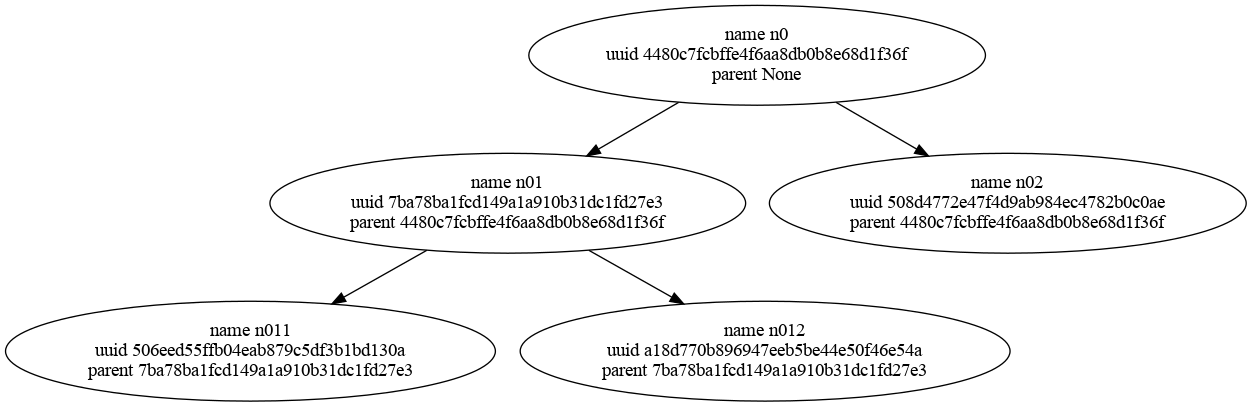

In [16]:
draw(dotstr)


In [17]:
db.visualize(path=ids)

'simple_graph.dot'

In [18]:
cat simple_graph.dot


digraph {
"4480c7fcbffe4f6aa8db0b8e68d1f36f" [label="name n0\nuuid 4480c7fcbffe4f6aa8db0b8e68d1f36f\nparent None"];
"7ba78ba1fcd149a1a910b31dc1fd27e3" [label="name n01\nuuid 7ba78ba1fcd149a1a910b31dc1fd27e3\nparent 4480c7fcbffe4f6aa8db0b8e68d1f36f"];
"508d4772e47f4d9ab984ec4782b0c0ae" [label="name n02\nuuid 508d4772e47f4d9ab984ec4782b0c0ae\nparent 4480c7fcbffe4f6aa8db0b8e68d1f36f"];
"506eed55ffb04eab879c5df3b1bd130a" [label="name n011\nuuid 506eed55ffb04eab879c5df3b1bd130a\nparent 7ba78ba1fcd149a1a910b31dc1fd27e3"];
"a18d770b896947eeb5be44e50f46e54a" [label="name n012\nuuid a18d770b896947eeb5be44e50f46e54a\nparent 7ba78ba1fcd149a1a910b31dc1fd27e3"];
"4480c7fcbffe4f6aa8db0b8e68d1f36f" -> "7ba78ba1fcd149a1a910b31dc1fd27e3" [label="parent 4480c7fcbffe4f6aa8db0b8e68d1f36f"];
}


In [21]:
db.find_neighbors(n01.uuid)

[('7ba78ba1fcd149a1a910b31dc1fd27e3',
  '506eed55ffb04eab879c5df3b1bd130a',
  '{"parent":"7ba78ba1fcd149a1a910b31dc1fd27e3"}'),
 ('7ba78ba1fcd149a1a910b31dc1fd27e3',
  'a18d770b896947eeb5be44e50f46e54a',
  '{"parent":"7ba78ba1fcd149a1a910b31dc1fd27e3"}'),
 ('4480c7fcbffe4f6aa8db0b8e68d1f36f',
  '7ba78ba1fcd149a1a910b31dc1fd27e3',
  '{"parent":"4480c7fcbffe4f6aa8db0b8e68d1f36f"}')]

In [23]:
db.find_neighbors(n02.uuid)

[('4480c7fcbffe4f6aa8db0b8e68d1f36f',
  '508d4772e47f4d9ab984ec4782b0c0ae',
  '{"parent":"4480c7fcbffe4f6aa8db0b8e68d1f36f"}')]

In [25]:
db.remove_node('4480c7fcbffe4f6aa8db0b8e68d1f36f')

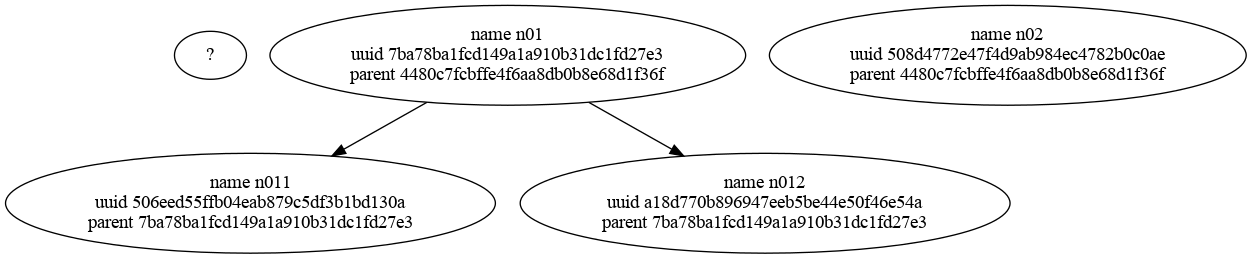

In [29]:
dotstr = db.get_dot(path=ids)
draw(dotstr)